In [4]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
import paf_loader
from os.path import join, isdir, isfile
import numpy as np
import cv2
from cselect import color as cs
from time import time
from reid import reid

from mvpose.data import umpm
from mvpose.algorithm.settings import get_settings, get_tracking_settings

from mvpose.algorithm import settings

gc_radius = 0
params = settings.get_settings(
    gc_radius=gc_radius,
    ms_radius=30)


root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
tmp = Settings['tmp']

# **************************** #
FRAME = 51 * 30  # 51*30, 31*30
FRAME = 1430
#FRAME = 0
# **************************** #

X, Y, Calib = umpm.get(root, 'p2_free_1', user, pwd)

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', Im, 
                                                        FRAME, 
                                                        dir=tmp)


# ==================================
from mvpose import pose
from mvpose.algorithm import graphcut

_start = time()
Debug, detections = pose.estimate_heuristic(
    Calib, heatmaps, pafs, 
    settings=params, debug=True, use_greedy=False)
_end = time()
print('\ntotal elapsed:', _end - _start)
# ==================================

UMPM
step 1: elapsed 1.244335412979126
step 2: elapsed 0.015429019927978516
step 3: elapsed 0.12363648414611816
step 4: elapsed 0.6140923500061035
-------------------------------------------
Handle transitivity:
	Intra:		 15
	Intra(choice):	 0
	Inter:		 80
	Inter(choice):	 93
-------------------------------------------
	Time =  110  ms
	result: 0

	Total cost: 1593.1199596895035

# valid points:		 97
# invalid points:	 1
step 5: elapsed 0.118011474609375
(smart candidate selection) [
	Time =  6  ms
	result: 0

	Total cost: 15.183595517904095
] (smart candidate selection)
step 7: elapsed 0.03783154487609863

total elapsed: 2.1546213626861572


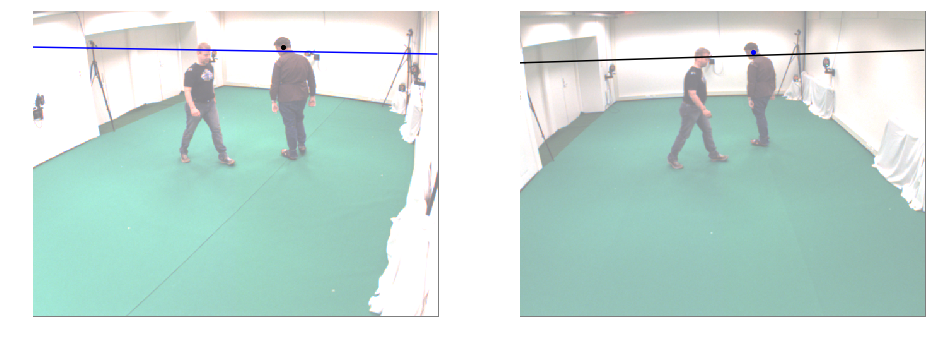

In [6]:
import mvpose.geometry.stereo as stereo

jid = 17
cam1 = 0
cam2 = 2

# ------------------------
def draw_peaks(ax, cid, colors):
    peaks2d = Debug.candidates2d.peaks2d[cid][jid]
    for i, (x, y, s) in enumerate(peaks2d):
        ax.scatter(x, y, color=colors[i], s=s*20)

# ------------------------

pts2d_1 = Debug.candidates2d.peaks2d_undistorted[cam1][jid][:, 0:2]
pts2d_2 = Debug.candidates2d.peaks2d_undistorted[cam2][jid][:, 0:2]


    

get_y = lambda a, b, c, x: (-c - a * x)/b

NOSE_1_COLORS = ['black', 'red']
NOSE_2_COLORS = ['blue', 'green']

im1 = Im[cam1]
im2 = Im[cam2]

P1 = Calib[cam1].P
P2 = Calib[cam2].P
F = stereo.get_fundamental_matrix(P1, P2)

epilines_1to2 = np.squeeze(
    cv2.computeCorrespondEpilines(pts2d_1, 1, F))
if len(epilines_1to2.shape) <= 1:
    epilines_1to2 = np.expand_dims(epilines_1to2, axis=0)
    
epilines_2to1 = np.squeeze(
    cv2.computeCorrespondEpilines(pts2d_2, 2, F))
if len(epilines_2to1.shape) <= 1:
    epilines_2to1 = np.expand_dims(epilines_2to1, axis=0)

fig = plt.figure(figsize=(16,12))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(im1, alpha=0.5)
ax.axis('off')
draw_peaks(ax, cam1, NOSE_1_COLORS)

for i, (a, b, c) in enumerate(epilines_2to1):
    x1 = 0
    y1 = get_y(a, b, c, x1)
    x2 = 640
    y2 = get_y(a, b, c, x2)

    
    ax.plot([x1, x2], [y1, y2], color=NOSE_2_COLORS[i])


ax = fig.add_subplot(1, 2, 2)
ax.imshow(im2, alpha=0.5)
ax.axis('off')
draw_peaks(ax, cam2, NOSE_2_COLORS)

for i, (a, b, c) in enumerate(epilines_1to2):
    x1 = 0
    y1 = get_y(a, b, c, x1)
    x2 = 640
    y2 = get_y(a, b, c, x2)
    ax.plot([x1, x2], [y1, y2], color=NOSE_1_COLORS[i])
    

plt.show()
